## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [162]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 5]


def abs_thresh(img, thresh_min=0, thresh_max=255):
    img_int8 = np.uint8(255 * img / np.max(img))
    binary_output = np.zeros_like(img_int8)
    binary_output[(img_int8 >= thresh_min) & (img_int8 <= thresh_max)] = 1
    return binary_output


def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
   
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image

    return binary_output


## Camera Callibration

Callibration of the camera is done using chessboard images provided in the `camera_cal` folder. 

I have used object possitions that were provided for each image.

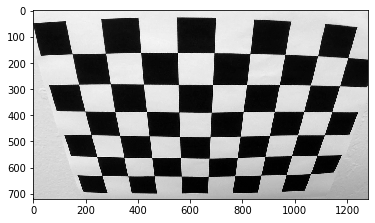

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

img = cv2.imread('camera_cal/calibration2.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

In [199]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


board_size =  (9,6)


# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, board_size, corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [200]:
# callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)


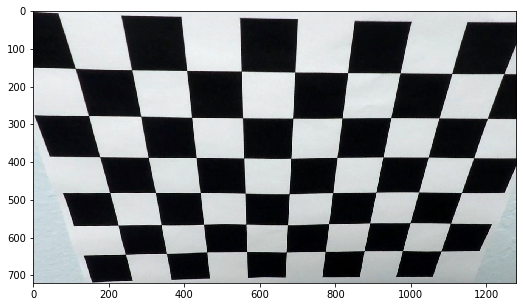

In [201]:
# Check how undistorted image looks
img = cv2.imread('camera_cal/calibration2.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

## Apply filters and masking to identify lane pixels

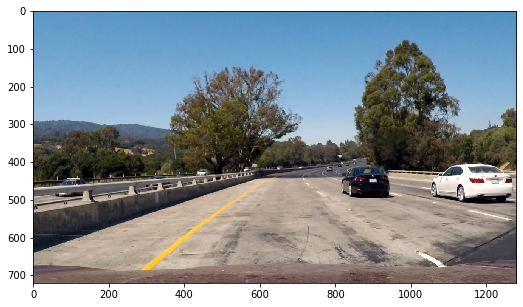

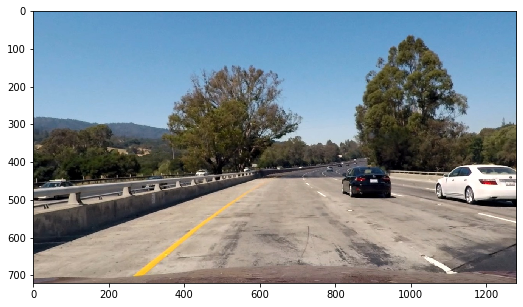

In [204]:

img_original = cv2.imread('test_images/test1.jpg')
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original_rgb)
plt.show()

img = cv2.undistort(img_original, mtx, dist, None, mtx)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


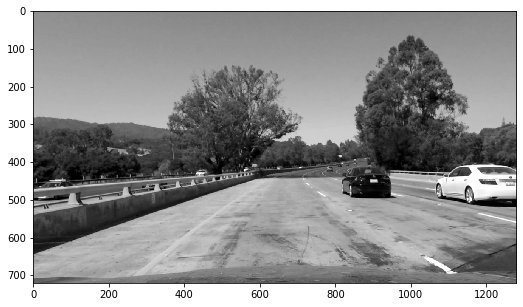

In [205]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = "gray")

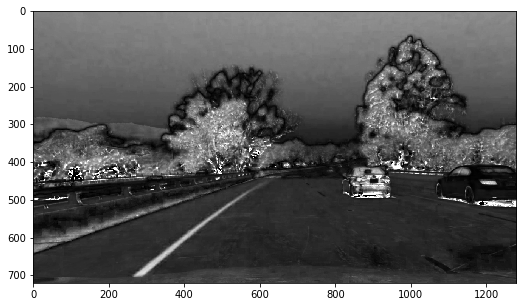

In [206]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
S = hsv[:,:, 1]
plt.imshow(S, cmap = "gray")

In [207]:
# Make threshold bit map from S layer

S = np.uint8(S / np.max(S) * 255)

Saturation layer compensates for shadows and color intensity changes. 
It also allows for good detection of the yellow lines wich is usually a problem in gray images. 

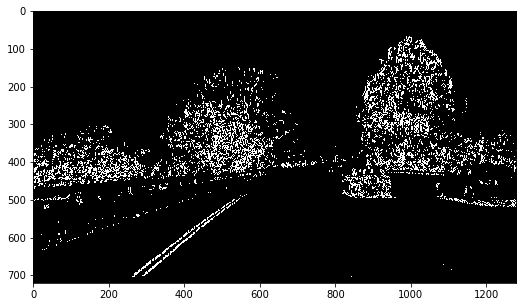

In [208]:
# Apply x Sobel on S
s_grad_x_binary = abs_sobel_thresh(S, orient='x', thresh_min=20, thresh_max=100)

plt.imshow(s_grad_x_binary, cmap='gray')

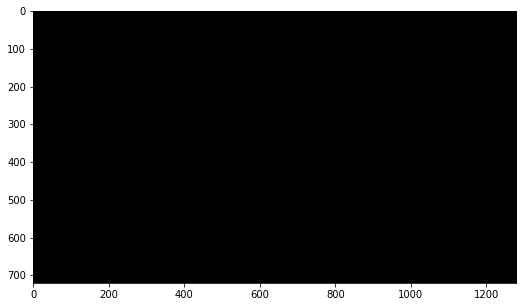

In [209]:
# Apply binary thresholding on S
s_binary = abs_thresh(S, thresh_min=100, thresh_max=255)
plt.imshow(s_binary, cmap='gray')

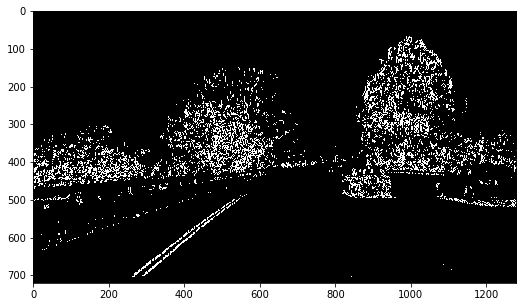

In [210]:
hsv_bw_ro = cv2.bitwise_or(s_binary,s_grad_x_binary)
plt.imshow(hsv_bw_ro, cmap='gray')

## Apply sobel and intensity threshold on color layer

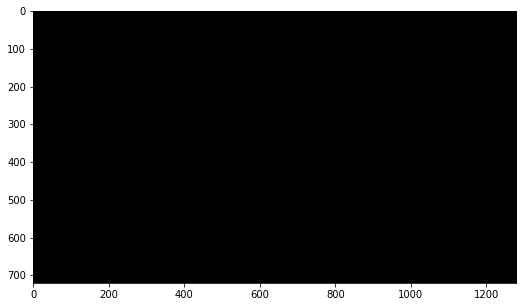

In [211]:
gray_binary = abs_thresh(gray, thresh_min=100, thresh_max=255)
plt.imshow(gray_binary, cmap='gray')


[[ 97  96  96 ...  87  86  85]
 [ 97  97  97 ...  87  85  85]
 [ 98  98  97 ...  86  86  86]
 ...
 [105 104 105 ... 125 123 121]
 [109 109 109 ... 126 125 124]
 [112 111 111 ... 126 127 127]]
0
255


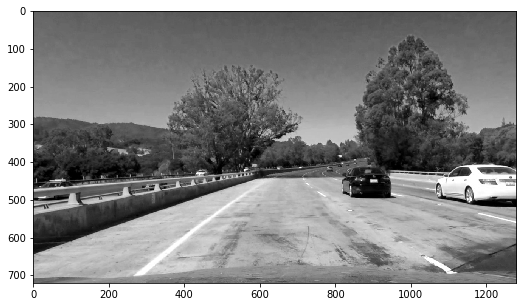

In [212]:
R = img[:, :, 2]

plt.imshow(R, cmap = "gray")
print(R)
print(np.min(R))
print(np.max(R))

0
0


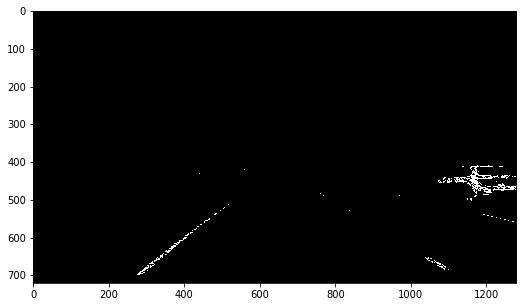

[[ 97  96  96 ...  87  86  85]
 [ 97  97  97 ...  87  85  85]
 [ 98  98  97 ...  86  86  86]
 ...
 [105 104 105 ... 125 123 121]
 [109 109 109 ... 126 125 124]
 [112 111 111 ... 126 127 127]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


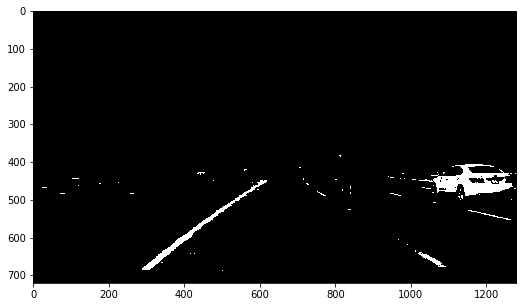

In [213]:
thresh_min=220
thresh_max=255
r_binary = abs_thresh(R, thresh_min=100, thresh_max=255)
print(np.min(r_binary))
print(np.max(r_binary))


img_int8 = np.uint8(R // np.max(R) * 255 )
plt.imshow(img_int8, cmap='gray')
plt.show()
print(R)
print(img_int8)
r_binary_output = np.zeros_like(img_int8)
r_binary_output[(R >= thresh_min) & (R <= thresh_max)] = 1

plt.imshow(binary_output, cmap='gray')


## Sobel on tne gray scale

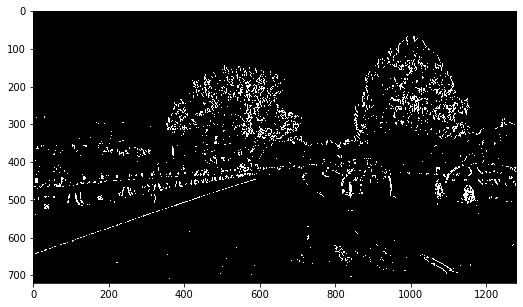

In [214]:
gray_grad_x_binary = abs_sobel_thresh(gray, orient='x', thresh_min=30, thresh_max=200)
plt.imshow(gray_grad_x_binary, cmap='gray')

## Sobel on tne Red channel

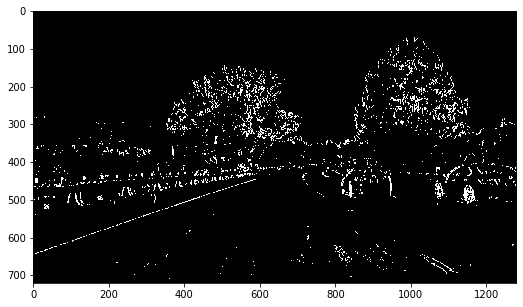

In [215]:
r_grad_x_binary = abs_sobel_thresh(R, orient='x', thresh_min=30, thresh_max=255)
plt.imshow(r_grad_x_binary, cmap='gray')

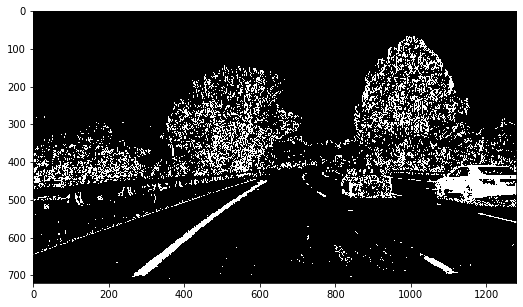

In [216]:
# combine binaries into resulting one

rgb_output_binary = cv2.bitwise_or(r_binary_output, gray_grad_x_binary)
output_binary = cv2.bitwise_or(hsv_bw_ro, rgb_output_binary)
plt.imshow(output_binary, cmap='gray')

(720, 1280)


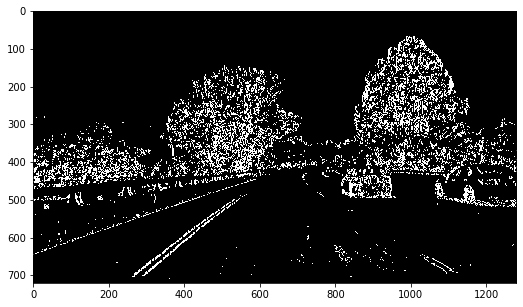

In [223]:
# cobined S and R Sobel x gradients only

output_binary = cv2.bitwise_or(s_grad_x_binary, gray_grad_x_binary)
plt.imshow(output_binary, cmap='gray')
print(output_binary.shape)

If cars are filtered out by segmenting out the road ahead or perspective transformation, combined binary looks good enough to proceed with the next steps.

## Change image perspective to have a bird eye view on the road

First, we can use the straight lines image taken on the long stretch of the road to calibrate parameters of the perspective transformation.

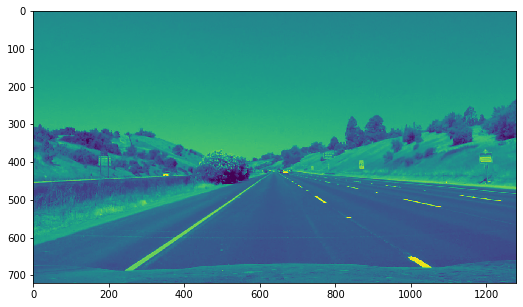

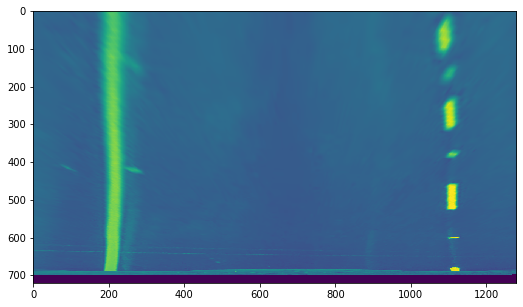

In [265]:
img_original = cv2.imread('test_images/straight_lines1.jpg') 
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
plt.imshow(img_original) 
plt.show()

src =  np.float32([[500, 515], [760, 500], [200, 720], [1100, 720]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])

dst = np.float32([[200, 500], [1100, 500], [200, 700], [1110, 700]])
  
  
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img_original, M, (1280, 720), flags=cv2.INTER_LINEAR)
plt.imshow(warped)  
    

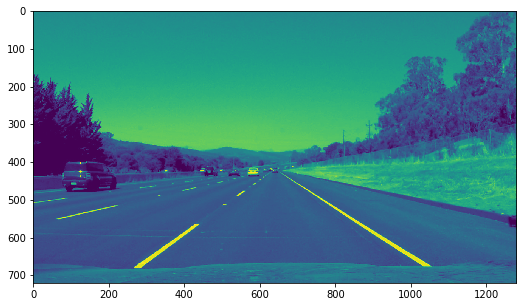

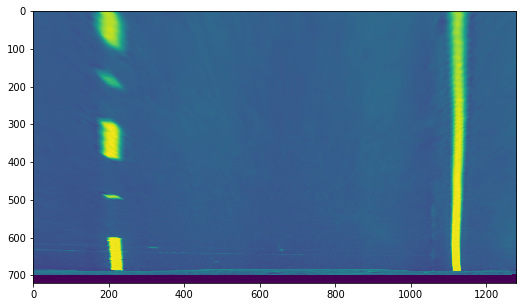

In [266]:
img_original = cv2.imread('test_images/straight_lines2.jpg') 
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

plt.imshow(img_original) 
plt.show()


warped = cv2.warpPerspective(img_original, M, (1280, 720), flags=cv2.INTER_LINEAR)
plt.imshow(warped)  

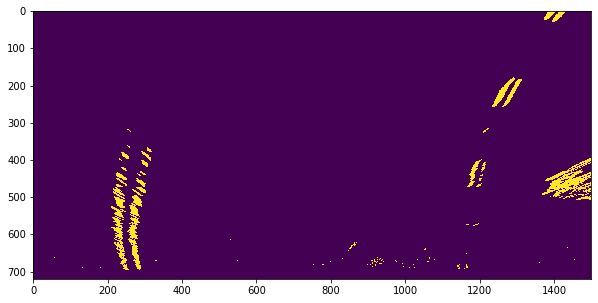

In [268]:
warped = cv2.warpPerspective(output_binary, M, (1500, 720), flags=cv2.INTER_LINEAR)
plt.imshow(warped) 

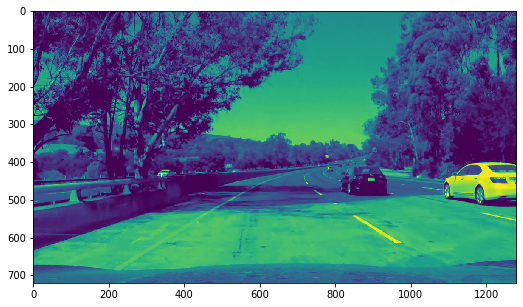

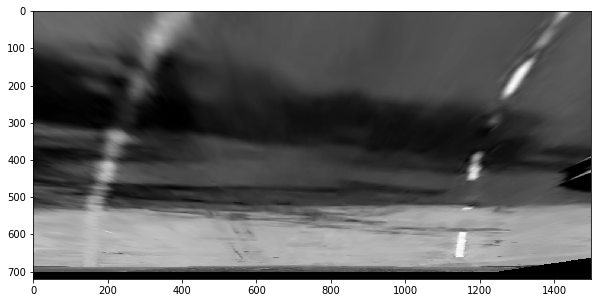

In [273]:
img_original = cv2.imread('test_images/test5.jpg') 
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

plt.imshow(img_original) 
plt.show()


warped = cv2.warpPerspective(img_original, M, (1500, 720), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap = 'gray')  